สมมติว่าอยู่ดี ๆ เราก็หายใจลำบาก หอบตัวโยน โดยไม่มีสาเหตุ ไม่มีอาการล่วงหน้าใด ๆ หรือว่าเราจะเป็น ภาวะปอดรั่ว  เราจะมาใช้ AI ช่วยวินิจฉัยเรื่องนี้กัน

Pneumothorax หรือ ภาวะปอดรั่ว คือการที่มีอากาศรั่วไหลเข้าไปอยู่ในช่องระหว่างปอด และ ผนังอกด้านใน ทำให้เบียดเนื้อปอดให้ขยายตัวได้ไม่เต็มที่ ปอดทำงานได้ไม่ดี ส่งผลต่อการหายใจ ภาวะปอดรั่วนี้ต้องได้รับการดูแลจากแพทย์โดยด่วน หากปล่อยไว้จะเป็นอันตรายถึงแก่ชีวิตได้

Pneumothorax หรือ ภาวะปอดรั่ว  เป็นภาวะที่พบได้ในอุบัติเหตุที่มีการกระแทกบริเวณหน้าอก มีลมซึมเข้ามาจากภายนอกทรวงอก หรือเกิดขึ้นเองจากการติดเชื้อภายใน โรคเกี่ยวกับปอด หอบหืด มะเร็งปอด etc. 

Pneumothorax หรือ ภาวะปอดรั่ว มักจะถูกวินิจฉัยโดย Radiologist (แพทย์รังสีวิทยา) อ่านฟิล์ม X-Ray แต่บางครั้งก็เป็นการยากที่จะยืนยันภาวะปอดรั่ว 

AI วิจิฉัยภาวะปอดรั่ว (Pneumothorax) อย่างแม่นยำ จะเป็นประโยชน์อย่างมาก ในการช่วยคัดแยกผู้ป่วย ในสถานพยาบาล จัดลำดับความสำคัญตามอาการมากน้อย หรือช่วยในการวินิจฉัยเบื้องต้น สำหรับบุคลากรทางการแพทย์ที่ไม่ใช่ Radiologist (แพทย์รังสีวิทยา)


In [0]:
# Github URL
# https://github.com/gnoparus/bualabs/blob/master/nbs/03b-image-segmentation-siim-acr-pneumothorax-segmentation.ipynb

# 0. Install

In [2]:
! nvidia-smi

Sat May 30 05:14:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

เราจะต้อง Install kaggle เพื่อ Download Dataset

In [0]:
# # Colab
# ! curl -s https://course.fast.ai/setup/colab | bash

# ! pip install kaggle --upgrade -q
# ! pip install pydicom -q
# ! pip install kornia -q

เช็ค [GPU](https://www.bualabs.com/archives/1426/why-gpu-require-train-deep-learning-compare-cpu-vs-gpu-deep-neural-network-hardware-ep-2/) Memory ใน Colab

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU

# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm() 

สำหรับ Clear Memory

In [0]:
# !kill -9 -1

# 1. Import Library

Import pydicom สำหรับเปิดไฟล์ภาพเอ็กซ์เรย์ DICOM นามสกุล dcm และ Libray อื่น ๆ ที่เราต้องการใช้

In [0]:
import math
import numpy as np
import pandas as pd

import os
import glob

import pydicom

from pathlib import Path
from matplotlib import cm
from matplotlib import pyplot as plt

import fastai
from fastai.vision import *

from kornia.losses import focal

In [7]:
fastai.__version__

'1.0.61'

# 2. เตรียม Path สำหรับดาวน์โหลดข้อมูล

กำหนด path ของ Config File และ Dataset ว่าจะอยู่ใน Google Drive ถ้าเราใช้ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) หรือ อยู่ใน HOME ถ้าเราใช้ VM ธรรมดา และกำหนด Environment Variable ไปยังโฟลเดอร์ที่เก็บ kaggle.json

ในกรณีใช้ Colab ให้ Mount Google Drive เพื่อดึง Config File มาจาก Google Drive ส่วนตัวของเรา เมื่อเรารัน Cell ด้านล่างจะมีลิงค์ปรากฎขึ้นมาให้เรา Login กด Approve แล้ว Copy Authorization Code มาใส่ในช่องด้านล่าง แล้วกด Enter

ในเคสนี้เราจะดึงข้อมูลจากหลาย Dataset เนื่องจากเราจะใช้การเทรนแบบ Progressive Resizing ใช้รูปหลายขนาดในการเทรน 

In [8]:
dataset = 'siim-acr-pneumothorax-segmentation'
dataset2 = 'jesperdramsch/siim-acr-pneumothorax-segmentation-data'
dataset3 = 'iafoss/siimacr-pneumothorax-segmentation-data-128'
dataset4 = 'iafoss/siimacr-pneumothorax-segmentation-data-256'
dataset5 = 'iafoss/siimacr-pneumothorax-segmentation-data-512'
dataset6 = 'iafoss/siimacr-pneumothorax-segmentation-data-1024'
dataset_test = 'ivanzhovannik/siim_stage2_png'

# Google Colab
config_path = Path('/content/drive')
learner_path = config_path/"My Drive"
data_path_base = Path('/content/datasets/')

data_path = data_path_base/dataset
data_path2 = data_path_base/dataset2
data_path3 = data_path_base/dataset3
data_path4 = data_path_base/dataset4
data_path5 = data_path_base/dataset5
data_path6 = data_path_base/dataset6
data_path_test = data_path_base/dataset_test

from google.colab import drive
drive.mount(str(config_path))
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

# # VM
# config_path = Path(os.getenv("HOME"))
# learner_path = config_path
# data_path = config_path/"datasets"/dataset
# data_path2 = config_path/"datasets"/dataset2
# data_path3 = config_path/"datasets"/dataset3
# data_path4 = config_path/"datasets"/dataset4
# data_path5 = config_path/"datasets"/dataset5
# data_path6 = config_path/"datasets"/dataset6
# data_path_test = config_path/"datasets"/dataset_test

# data_path.mkdir(parents=True, exist_ok=True)
# os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/.kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Dataset

ในเคสนี้ เราจะ Download ข้อมูล Dataset ที่เกี่ยวข้องทั้งหมดมาเก็บไว้ แบ่งเป็นรูปฟิล์ม X-Ray ขนาดต่าง ๆ ข้อมูลต้นฉบับ ข้อมูล Test Set, etc.

Dataset เราจะดึงจาก Kaggle วิธี Download kaggle.json ให้ดูจาก ep ที่แล้ว

เมื่อได้ kaggle.json มาแล้ว ในกรณีใช้ Google Colab ให้นำมาใส่ไว้ในโฟลเดอร์ My Drive/.kaggle ใน Google Drive ของเรา เป็น My Drive/.kaggle/kaggle.json ถ้าใช้ VM ให้ใส่ใน HOME/.kaggle/

สั่งดาวน์โหลด Dataset จาก Kaggle พร้อมทั้ง unzip ไว้ใน data_path

In [0]:
# !kaggle competitions download -c {dataset} -p "{data_path}"
# !kaggle datasets download {dataset2} -p "{data_path2}" --unzip
# !kaggle datasets download {dataset3} -p "{data_path3}" --unzip
# !kaggle datasets download {dataset4} -p "{data_path4}" --unzip
# !kaggle datasets download {dataset5} -p "{data_path5}" --unzip
# ## !kaggle datasets download {dataset6} -p "{data_path6}" --unzip
# !kaggle datasets download {dataset_test} -p "{data_path_test}" --unzip

Unzip ไฟล์ที่ดาวน์โหลดจาก Kaggle Competition

In [0]:
# ! unzip -q {data_path}/siim-acr-pneumothorax-segmentation.zip -d {data_path}
# ! unzip -q {data_path}/stage_2_images.zip -d {data_path}/stage_2_images
# ! unzip -q {data_path}/stage_2_train.csv.zip -d {data_path}

Import ฟังก์ชันสำหรับแปลงข้อมูล Label ที่อยู่ในรูปแบบ Run-length encoding (RLE) to Mask ที่ให้มากับ Dataset

In [0]:
import sys
sys.path.insert(0, str(data_path))

from mask_functions import *

# 4. Data

## 4.1 DICOM Image

เปิดดูข้อมูลฟิล์มเอ็กซ์เรย์

In [0]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


วนลูปเปิดดูไฟล์ DICOM ที่จะมีทั้งรูป และ Metadata ข้อมูลประกอบ อยู่ในไฟล์เดียวกัน

Filename.........: /content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.11798.1517875234.913351/1.2.276.0.7230010.3.1.3.8323329.11798.1517875234.913350/1.2.276.0.7230010.3.1.4.8323329.11798.1517875234.913352.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: fc5c92fd-e254-4e8b-b0fd-ba345f98eb5d, 
Patient id..........: fc5c92fd-e254-4e8b-b0fd-ba345f98eb5d
Patient's Age.......: 64
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 165962 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]


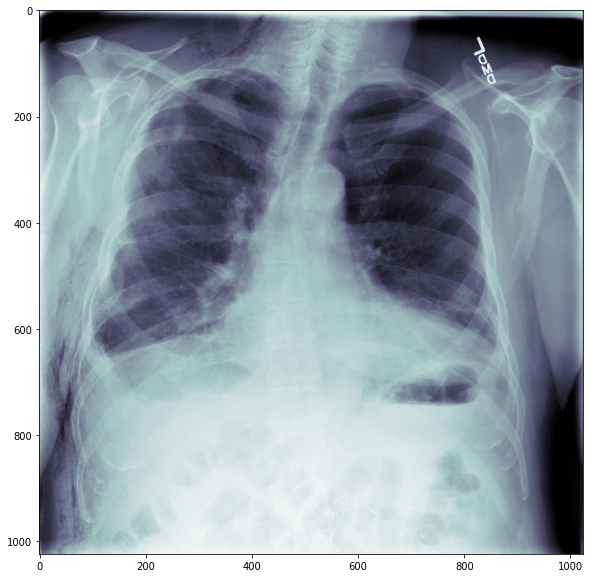

In [13]:
for file_path in glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm')):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    break # Comment this out to see all

ลองดูทีละหลาย ๆ ไฟล์

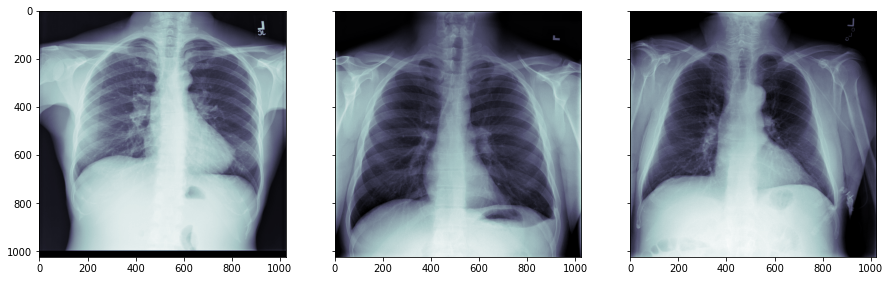

In [14]:
start = 22   # Starting index of images
num_img = 3 # Total number of images to show

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*5,5))
for q, file_path in enumerate(glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm'))[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)


ดู Label ที่มาในรูปแบบ Run-length encoding (RLE) ดังที่เห็นใน Column EncodedPixels 

-1 หมายถึง ปอดปกติ

In [15]:
df = pd.read_csv(data_path2/'train-rle.csv', index_col=0)
df.head()

,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1
1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [16]:
df.shape

(11582, 1)

## 4.2 Mask

ใช้ฟังก์ชันที่ได้มา แปลง RLE เป็น Mask ขนาด 1024 x 1024

In [17]:
mask = rle2mask(df.loc['1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709'][0].strip(), 1024, 1024).T
# a = mask.sum(axis=1)
# a = mask.sum(axis=0)
# a.argmax()

mask[105:115, 300:310]

array([[  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0.,   0., ..., 255., 255., 255., 255.],
       [  0.,   0.,   0., 255., ..., 255., 255., 255., 255.],
       [  0., 255., 255., 255., ..., 255., 255., 255., 255.],
       [255., 255., 255., 255., ..., 255., 255., 255., 255.]])

เพื่อให้เห็นชัด ๆ เราจะแปลงเป็น Transparent ไว้สำหรับ Overlay กับภาพฟิล์ม X-Ray

In [18]:
mask_rgba = mask/255
mask_rgba = np.repeat(mask_rgba[:, :, np.newaxis], 4, axis=2)
mask_rgba[:, :, [1,2]] = 0
mask_rgba[:, :, 3] = mask_rgba[:, :, 3]*0.7

mask_rgba[105:115, 300:310, 0]

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 1., ..., 1., 1., 1., 1.],
       [0., 1., 1., 1., ..., 1., 1., 1., 1.],
       [1., 1., 1., 1., ..., 1., 1., 1., 1.]])

ลองแสดง Mask เป็นรูป

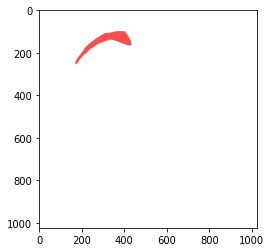

In [19]:
plt.imshow(mask_rgba)

## 4.3 DICOM Image and Mask

แสดงฟิล์ม X-Ray พร้อมระบายสี Pneumothorax ด้วย Mask สีแดง

In [0]:
start = 44   # Starting index of images
num_img = 3 # Total number of images to show

1.2.276.0.7230010.3.1.4.8323329.3245.1517875176.864282.dcm
Nothing to see
1.2.276.0.7230010.3.1.4.8323329.2431.1517875172.700478.dcm
Nothing to see
1.2.276.0.7230010.3.1.4.8323329.11370.1517875232.645517.dcm
Nothing to see


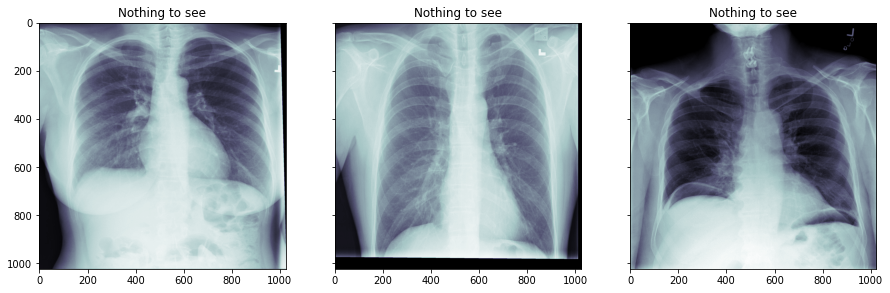

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*5,5))
for q, file_path in enumerate(glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm'))[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    print(file_path.split('/')[-1])
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    fn = file_path.split('/')[-1][:-4]
    rle = df.loc[fn][0].strip()
    # print(rle)
    if rle != '-1':
        print('See Marker')
        mask = rle2mask(rle, 1024, 1024).T
        ax[q].set_title('See Marker')
#         # Normal Mask
#         ax[q].imshow(mask, alpha=0.3, cmap="rainbow")
        
        # Make alpha mask
        mask_rgba = mask/255
        mask_rgba = np.repeat(mask_rgba[:, :, np.newaxis], 4, axis=2)
        mask_rgba[:, :, [1,2]] = 0
        mask_rgba[:, :, 3] = mask_rgba[:, :, 3]*0.4

        ax[q].imshow(mask_rgba)
    else:
        print('Nothing to see')
        ax[q].set_title('Nothing to see')


# 5. Data Pipeline

เมื่อเราได้รูปด้านบนมาแล้ว เพื่อความสำดวก เราจะแปลงทั้งหมดเป็นไฟล์รูป .png เนื่องจาก Lossless แล้ว Resize เป็นขนาดต่าง ๆ ใส่ไว้ใน Folder ที่กำหนด ซึ่งมีคนทำไว้ให้เราแล้ว เราก็ไป Download มาใน Dataset 3, 4, 5, 6

กำหนด [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/), ขนาดของรูปที่จะเทรน และ Path ที่เก็บรูป

In [0]:
bs=48

SZ = 128
path = data_path3

ประกาศ Class และฟังก์ชัน ที่ใช้ใน [Data Pipeline](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) ในงาน [Semantic Segmentation](https://www.bualabs.com/archives/835/image-segmentation-semantic-segmentation-camvid-machine-learning-unet-deep-learning-image-segmentation-ep-1/)

In [0]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

ใช้ [DataBlock API](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) สร้าง [DataBunch](https://www.bualabs.com/archives/2318/databunch-learner-refactor-neural-network-training-loop-neural-network-ep-9/) เตรียมส่งให้ Model สำหรับเทรน โดย [Train/Validation Split](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) 80/20, แต่ละ Pixel เป็น Binary Classification 0/1 , ทำ [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) ทุกอย่างยกเว้น Flip Vertical แล้ว [Normalize](https://www.bualabs.com/archives/2100/what-is-normalization-feature-scaling-rescaling-normalization-standardization-feedforward-train-machine-learning-preprocessing-ep-2/) ด้วย imagenet_stats

In [24]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:500]
        .split_by_rand_pct(0.2, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        .add_test((data_path_test).ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize(imagenet_stats))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


ได้ Traing Set และ Validation Set จำนวนดังนี้

In [25]:
len(data.train_ds), len(data.valid_ds)

(9638, 2409)

ดูข้อมูล 1 Batch 

In [0]:
# data.show_batch(rows=3, figsize=(12, 12))

# 6. Model

## 6.1 Dice Metric

Dice หรือ Sørensen–Dice coefficient เป็นการคำนวนสถิติที่ใช้วัดค่าความเหมือนกัน ของ 2 ข้อมูลตัวอย่าง ดังสมการด้านล่าง รายละเอียดเพิ่มเติมใน ep [Metrics / Confusion Matrix](https://www.bualabs.com/archives/1968/what-is-metrics-confusion-matrix-accuracy-precision-recall-f1-score-difference-metrics-ep-1/)

$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|} = \frac{2 TP}{2 TP + FP + FN} $$

## 6.2 U-Net and ResNet34

เราจะใช้ [Model Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) เหมือน ep ที่แล้ว คือ U-Net และ ResNet34 แปลงโมเดลเป็นแบบ Mixed Precision Training และใช้ [Focal Loss](https://www.bualabs.com/archives/4227/what-is-focal-loss-loss-function-ep-4/) แทน Cross Entropy Loss ตามปกติ

In [0]:
class CustomFocalLoss(focal.FocalLoss):
    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none') -> None:
        super(CustomFocalLoss, self).__init__(alpha, gamma, reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)
    def forward(  # type: ignore
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:        
        return super().forward(input, target.squeeze(1))    

In [0]:
kwargs = {"alpha": 0.5, "gamma": 2.0, "reduction": 'mean'}
loss_func = CustomFocalLoss(**kwargs)

In [0]:
learn = unet_learner(data, models.resnet34, metrics=[dice], self_attention=True, 
                     blur=True, norm_type=NormType.Weight, 
                     loss_func=loss_func, path=learner_path, 
                     callback_fns=ShowGraph).to_fp16()

In [0]:
# learn.summary()

# 7. Train

เราจะใช้ Progressive Resizing ข้อมูลตัวอย่างที่ป้อนให้กับโมเดล เหมือนใน [Image Segmentation ep.1](https://www.bualabs.com/archives/835/image-segmentation-semantic-segmentation-camvid-machine-learning-unet-deep-learning-image-segmentation-ep-1/) เริ่มต้น จาก 128, 256, 512 ไปจนถึง 1024 ที่เป็นขนาดต้นฉบับ 

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

## 7.1 Train Last Layer

In [0]:
lr = 1e-3

epoch,train_loss,valid_loss,dice,time
0,0.021465,0.020651,0.777086,01:16
1,0.007698,0.002791,0.754256,01:10
2,0.002773,0.002400,0.777086,01:10
3,0.002280,0.002036,0.770496,01:10


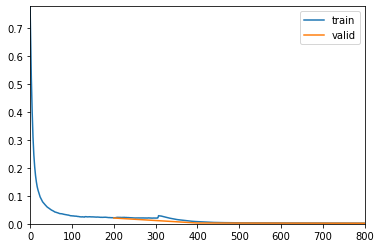

In [33]:
learn.fit_one_cycle(4, max_lr=lr, wd=1e-3, pct_start=0.8)

In [0]:
learn.save('03b-unet-resnet34-128-1')

In [0]:
learn.load('03b-unet-resnet34-128-1');

In [0]:
# learn.show_results(rows=4, figsize=(8, 16))

## 7.2 Unfreeze and Train Whole Model

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=0)

In [0]:
lr = slice(3e-6, 3e-4)

epoch,train_loss,valid_loss,dice,time
0,0.002177,0.002015,0.743649,01:14
1,0.002038,0.001978,0.772231,01:14
2,0.002059,0.002025,0.721479,01:14
3,0.001897,0.001910,0.770257,01:15
4,0.001764,0.001800,0.762509,01:14
5,0.001733,0.001743,0.769721,01:14
6,0.001764,0.001859,0.774759,01:15
7,0.001790,0.001700,0.764840,01:15
8,0.001548,0.001739,0.716623,01:15
9,0.001524,0.001817,0.770230,01:14


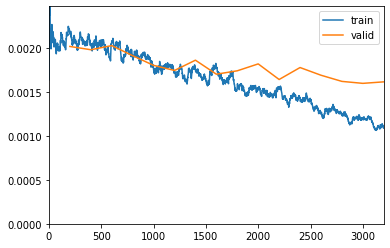

In [40]:
learn.fit_one_cycle(16, max_lr=lr, wd=1e-3, pct_start=0.7)

In [0]:
learn.save('03b-unet-resnet34-128-2')

In [0]:
learn.load('03b-unet-resnet34-128-2');

In [0]:
# learn.show_results(rows=4, figsize=(8, 16))

## 7.3 Increase Image size to 256 and Train Last Layer

In [44]:
learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [0]:
bs=32

SZ = 256
path = data_path4

คราวนี้ เราจะ Normalize ด้วยข้อมูล 1 Batch จาก Dataset ของเราเอง แทนที่จะใช้ imagenet_stats

In [46]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:500]
        .split_by_rand_pct(0.2, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        .add_test((data_path_test).ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [0]:
learn = unet_learner(data, models.resnet34, metrics=[dice], 
                     self_attention=True, blur=True, norm_type=NormType.Weight, 
                     loss_func=loss_func, path=learner_path, 
                     callback_fns=ShowGraph).to_fp16()

In [0]:
learn.load('03b-unet-resnet34-128-2')
learn.freeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

In [0]:
lr = 3e-4

epoch,train_loss,valid_loss,dice,time
0,0.001742,0.001795,0.767869,03:58
1,0.001660,0.001544,0.776578,03:45
2,0.001439,0.001415,0.782572,03:45


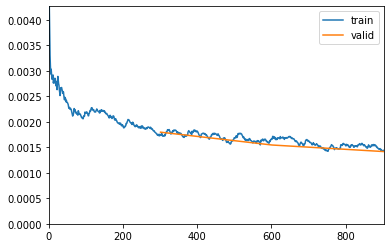

In [51]:
learn.fit_one_cycle(3, max_lr=lr, wd=1e-3, pct_start=0.8)

In [0]:
learn.save('03b-unet-resnet34-256-1')

In [0]:
learn.load('03b-unet-resnet34-256-1');

In [0]:
# learn.show_results(rows=4, figsize=(8, 16))

## 7.4 Unfreeze and Train Whole Model with 256

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=0)

In [0]:
lr = slice(3e-6, 1e-4)

epoch,train_loss,valid_loss,dice,time
0,0.001311,0.001436,0.786767,03:56


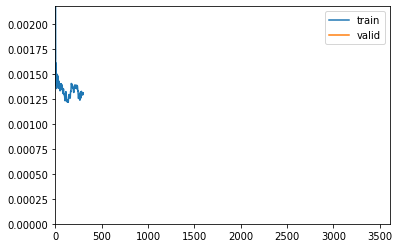

In [0]:
learn.fit_one_cycle(12, max_lr=lr, wd=1e-3, pct_start=0.7)

In [0]:
learn.save('03b-unet-resnet34-256-2')

In [0]:
learn.load('03b-unet-resnet34-256-2');

In [0]:
# learn.show_results(rows=4, figsize=(8, 16))

## 7.5 Increase Image size to 512 and Train Last Layer

In [0]:
learn.destroy()
gc.collect()

In [0]:
bs=8

SZ = 512
path = data_path5

In [0]:
# path.ls()

In [0]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:100]
        .split_by_rand_pct(0.2, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        .add_test((data_path_test).ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize())        

In [0]:
learn = unet_learner(data, models.resnet34, metrics=[dice], 
                     self_attention=True, blur=True, norm_type=NormType.Weight, 
                     loss_func=loss_func, path=learner_path, 
                     callback_fns=ShowGraph).to_fp16()

In [0]:
learn.load('03b-unet-resnet34-256-2')
learn.freeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

In [0]:
lr = 3e-4

In [0]:
learn.fit_one_cycle(2, max_lr=lr, wd=1e-3, pct_start=0.8)

In [0]:
learn.save('03b-unet-resnet34-512-1')

In [0]:
learn.load('03b-unet-resnet34-512-1');

In [0]:
# learn.show_results(rows=4, figsize=(8, 16))

## 7.6 Unfreeze and Train Whole Model with 512

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=0)

In [0]:
lr = slice(3e-6, 1e-4)

In [0]:
learn.fit_one_cycle(8, max_lr=lr, wd=1e-3, pct_start=0.7)

In [0]:
learn.save('03b-unet-resnet34-512-2')

In [0]:
learn.load('03b-unet-resnet34-512-2');

In [0]:
# learn.show_results(rows=4, figsize=(8, 16))

## 7.7 Data Augmentation Annealing

ก่อน Infer เราจะเทรนด้วยข้อมูลที่ไม่ได้ทำ [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) ตบท้าย

In [0]:
learn.destroy()
gc.collect()

In [0]:
bs=8

SZ = 512
path = data_path5

In [0]:
# path.ls()

In [0]:
transform_none = [[], []]
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:500]
        .split_by_rand_pct(0.01, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        .add_test((data_path_test).ls(), label=None)
        .transform(transform_none, size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize())

In [0]:
learn = unet_learner(data, models.resnet34, metrics=[dice], 
                     self_attention=True, blur=True, norm_type=NormType.Weight, 
                     loss_func=loss_func, path=learner_path,  
                     callback_fns=ShowGraph).to_fp16()

In [0]:
learn.load('03b-unet-resnet34-512-2');


In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

In [0]:
lr = slice(3e-6, 1e-4)

In [0]:
learn.fit_one_cycle(4, max_lr=lr, wd=1e-3, pct_start=0.7)

In [0]:
learn.save('03b-unet-resnet34-512-3')

In [0]:
learn.load('03b-unet-resnet34-512-3');

In [0]:
# learn.show_results(rows=4, figsize=(8, 16))

# 8. Make a Prediction

เทรนเสร็จแล้ว เราจะใช้โมเดลมาทำนายวินิจฉัย Pneumothorax หรือ ภาวะปอดรั่ว จากฟิล์ม X-Ray ใน Validation Set ที่เราแบ่งไว้ตอนแรก 20% ว่าจะตรงไหม

In [0]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

In [0]:
preds.shape, ys.shape

In [0]:
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

หา Threshold ให้ได้ ค่า Dice ที่ดีที่สุด

In [0]:
# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)

In [0]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

ดูผลลัพธ์ในการวิจิฉัยภาวะปอดรั่ว (Pneumothorax) จะเห็นเป็น Image Segmentation เป็นสีเหลืองเขียว บริเวณปอดที่มีภาวะปอดรั่ว (Pneumothorax) เทียบกับ Label จากข้อมูลตัวอย่างใน Dataset

จะเห็นว่าโมเดลของเราวินิจฉัยได้อย่างแม่นยำ 

In [0]:
# Plot some samples
rows = 5
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

# 10. Submit Predictions to Kaggle

ส่งผลการวินิจฉัยฟิล์ม X-Ray ใน Test Set ไปให้ Kaggle ตรวจ

In [0]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
preds = (preds[:,1,...]>best_thr).long().numpy()
print(preds.sum())

In [0]:
# Generate rle encodings (images are first converted to the original size)
rles = []
for p in progress_bar(preds):
    im = PIL.Image.fromarray((p.T*255).astype(np.uint8)).resize((1024,1024))
    im = np.asarray(im)
    rles.append(mask2rle(im, 1024, 1024))

แปลงจากรูป เป็น RLE เหมือนเดิม

In [0]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

In [0]:
sub_df.shape

In [0]:
sub_df.to_csv('submission.csv', index=False)

In [0]:
! kaggle competitions submit siim-acr-pneumothorax-segmentation -f {'submission.csv'} -m "My submission Focal Loss 01"



| Name           | Submitted    | Wait time | Execution time | Score   |
|----------------|--------------|-----------|----------------|---------|
| submission.csv | a day ago    | 0 seconds | 1 seconds      | 0.9060  |


เราได้ Public Leaderboard 0.9060, Private Leaderboard 0.8104 อยู่ที่อันดับ 280 จาก 1475 ดังตารางด้านล่าง = Top 20%

| #   	| Team Name      	| Score  	| Last 	|
|-----	|----------------	|--------	|------	|
| 278 	| UWRad          	| 0.8113 	| 2mo  	|
| 279 	| Mitul          	| 0.8105 	| 2mo  	|
| 280 	| diCELLa        	| 0.8096 	| 2mo  	|
| 281 	| lucaskg        	| 0.8094 	| 2mo  	|
| 282 	| Insaf Ashrapov 	| 0.8091 	| 2mo  	|



Top 10 ใน Private Leaderboard คือ อันดับที่ 147 จาก 1475 ทีม Dice = 0.8320 

# สรุป

* เราได้สร้าง AI วิจิฉัยภาวะปอดรั่ว (Pneumothorax) ที่ทำงานได้อย่าง อย่างแม่นยำพอสมควร ด้วยการเทรนโมเดล ด้วย GPU ไม่ถึง 24 ชั่วโมง
* แทนที่จะใช้รูป PNG จาก Dataset ที่คนทำไว้ให้แล้ว เราสามารถแปลงไฟล์เองจากไฟล์ DICOM ต้นฉบับ เลือก Window ข้อมูลที่เราต้องการ เพื่อปรับปรุ่งความแม่นยำให้มากขึ้น
* เราสามารถเพิ่มความซับซ้อนของโมเดล, รูปขนาดใหญ่ขึ้น, Loss Function, Multi-Head และใช้ GPU รุ่นใหม่ขึ้นในการเทรน ให้ได้ผลลัพธ์ที่แม่นยำมากขึ้น รวดเร็วขึ้นไปอีก
* เราสามารถประยุกต์ใช้โมเดลนี้ กับโรคที่คล้าย ๆ กันอีกหลายโรค ที่ต้องวินิจฉัยโดย Radiologist (แพทย์รังสีวิทยา) อ่านฟิล์ม X-Ray

# Credit

* https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/
* https://siim.org/
* https://www.bualabs.com/archives/835/image-segmentation-semantic-segmentation-camvid-machine-learning-unet-deep-learning-image-segmentation-ep-1/
* https://en.wikipedia.org/wiki/Pneumothorax
* https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data/
* https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
* https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data
* https://www.kaggle.com/iafoss/hypercolumns-pneumothorax-fastai-0-831-lb
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-128
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-256
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-512
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-1024
* https://www.kaggle.com/mnpinto/pneumothorax-fastai-u-net
* https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
* https://www.kaggle.com/meaninglesslives/unet-with-efficientnet-encoder-in-keras
* https://pydicom.github.io/pydicom/stable/getting_started.html
* https://docs.python.org/2/library/glob.html
* https://arxiv.org/abs/1505.04597
* https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available


